In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid']) # , 'nature'

#plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 1200

n_wheel = 4 # number of wheels
diameter = 0.8
radius = diameter/2
b_width = 0.35 # wheel width in m
h_grouser = 0.03 # grouser height
n_grouser = 8 # number of grousers
eta = 0.7 # gearbox efficiency
power_constant = 150*eta # constant power for the whole locomotion subsystem
v_rover_constant = 0.05 # km/h
c_b = 170 # N/m^2 coefficient of soil/wheel cohesion
n = 1 # exponent of soil deformation
k_c = 1400 # N/m^2 cohesive modulus of soil deformation
k_phi = 830000  # N/m^3 frictional modulus of soil deformation
K = 0.018  # coefficient of soil slip in m
gamma = 2470 # N/m3 lunar soil density
phi = 33 # deg soil internal friction angle
phi_rad = np.deg2rad(phi) # rad soil internal friction angle
mu = np.tan(phi_rad) # static friction coefficient
N_q = 32.23
N_c = 48.09
N_gamma = 33.27
K_c = 33.37
K_phi = 72.77
K_gamma = 81.93
mass = 1800 # mass of the rover
gravity = 1.62 # gravitational constant of the moon
slope = np.linspace(0, 25, 100)
#slope = 0
slip = 0.0353 + 1/(1+67*np.exp(-0.32*slope))
slip_old = 0.1 + (0.01 * slope)  # Adjust formula to fitting experimental wheel parameters
#slip = 1
k = (k_c / b_width) + k_phi
c_f = 0.05 # internal rolling friction coefficient (bearings)

W_vehicle = mass * gravity
W_vehicle_normal = W_vehicle * np.cos(np.deg2rad(slope))
W_wheel = mass * gravity / n_wheel
W_wheel_normal = W_wheel * np.cos(np.deg2rad(slope))

z_sinkage = (3 * W_wheel_normal / ((3 - n) * (k_c + b_width * k_phi) * np.sqrt(diameter))) ** (2/(2*n+1))
pressure = k * z_sinkage ** n

theta_1 = np.arccos(1 - z_sinkage / radius)
theta_m = (0.45 + 0.24 * slip) * theta_1
lever_e = radius * np.sin(theta_1 - theta_m)
lever_l = radius * np.cos(theta_1 - theta_m)
l_contact = (diameter / 2) * np.arccos(1 - (2 * z_sinkage / diameter))
A = b_width * l_contact
alpha = np.arccos(1 - 2 * z_sinkage / diameter) # angle of approach
l_0 = z_sinkage * np.tan(np.pi / 4 - phi_rad / 2) ** 2 # distance of rupture

R_compression = ((b_width * k) / (n+1)) * z_sinkage ** (n+1)
R_bulldozing = (b_width*np.sin(alpha+phi_rad) / (2*np.sin(alpha)*np.cos(phi_rad))) * (2*z_sinkage*c_b*K_c + gamma*K_gamma*z_sinkage**2) + ((gamma*l_0**3)/3) * (np.pi/2 - phi_rad) + (c_b*l_0**2) * (1+np.tan(np.pi/4 + phi_rad/2))
R_gravitational = W_wheel * np.sin(np.deg2rad(slope))
R_rolling = W_wheel_normal * c_f # internal (bearings)

sum_R = 4* R_compression + 2* R_bulldozing + 4* R_gravitational + 4* R_rolling
n_grouser_contact = 2 * np.pi * radius / (n_grouser * l_contact)

sum_H_grouser = 4* (A*c_b*(1+2*h_grouser/b_width)*n_grouser_contact + W_wheel_normal*mu*(1 + (0.64*h_grouser/b_width) * np.arctan(b_width/h_grouser))) * (1-np.exp(-slip * l_contact / K))

W_wheel_safe = A * (c_b*N_c + gamma*z_sinkage*N_q + gamma*b_width*N_gamma/2)
pressure_soil_safe = W_wheel_safe / A
pressure_real = W_wheel / A
pressure_margin = pressure_real / pressure_soil_safe
weight_margin = W_wheel / W_wheel_safe

drawbar_pull = sum_H_grouser - sum_R
torque = (((drawbar_pull * lever_l) + (W_vehicle_normal * lever_e))/n_wheel) + 28
omega = power_constant / (torque * n_wheel)
rpm = omega * 60/ (2 * np.pi)
v_rover = omega * radius * 3.6 * (1-slip)
power_variable = (v_rover_constant * torque * n_wheel) / (radius * 3.6 * (1-slip))

theta_max = np.rad2deg(np.arctan(drawbar_pull / W_vehicle))

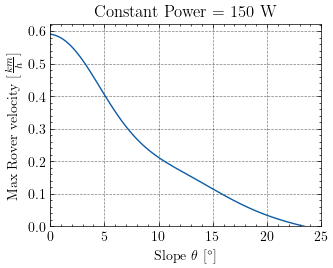

In [2]:
plt.plot(slope, v_rover)
plt.xlabel('Slope $\\theta$ [$^\circ$]')
plt.ylabel('Max Rover velocity [$\\frac{km}{h}$]')
plt.xlim(0, 25)
plt.ylim(0,)
plt.title('Constant Power = {:.0f} W'.format(power_constant/eta))
plt.savefig("max_rover_velocity_slope.pdf")
plt.savefig("max_rover_velocity_slope.png")
plt.show()

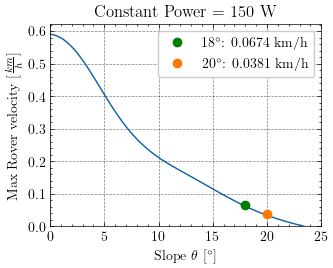

In [3]:
plt.plot(slope, v_rover)
plt.xlabel('Slope $\\theta$ [$^\circ$]')
plt.ylabel('Max Rover velocity [$\\frac{km}{h}$]')
plt.xlim(0, 25)
plt.ylim(0,)
plt.title('Constant Power = {:.0f} W'.format(power_constant/eta))

# Mark points at 18 and 20 degrees
plt.plot(18, v_rover[np.where(np.round(slope) == 18)][0], 'o', color='green', label=f'18$^\circ$: {v_rover[np.where(np.round(slope) == 18)][0]:.4f} km/h')
plt.plot(20, v_rover[np.where(np.round(slope) == 20)][0], 'o', color=(255/255, 120/255, 0/255), label=f'20$^\circ$: {v_rover[np.where(np.round(slope) == 20)][0]:.4f} km/h')

plt.legend()
plt.savefig("max_rover_velocity_slope_points.pdf")
plt.savefig("max_rover_velocity_slope_points.png")
plt.show()


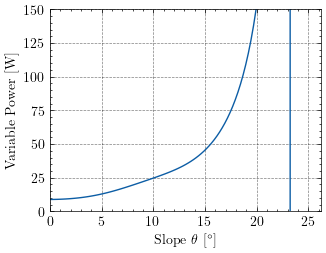

In [4]:
plt.plot(slope, power_variable)
plt.xlabel('Slope $\\theta$ [$^\circ$]')
plt.ylabel('Variable Power [W]')
plt.xlim(0,)
plt.ylim(0,150)
plt.savefig("power_variable_slope.pdf")
plt.savefig("power_variable_slope.png")
plt.show()

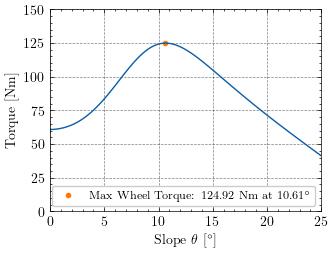

In [5]:
# Find the index of the maximum torque
max_torque_index = np.argmax(torque)
max_torque_value = torque[max_torque_index]
max_torque_theta = slope[max_torque_index]
plt.plot(max_torque_theta, max_torque_value, 'o', color=(255/255, 120/255, 0/255), markersize=3)
plt.plot(slope, torque)
plt.xlabel('Slope $\\theta$ [$^\circ$]')
plt.ylabel('Torque [Nm]')
plt.xlim(0, 25)
plt.ylim(0,150)
plt.legend([f'Max Wheel Torque: {max_torque_value:.2f} Nm at {max_torque_theta:.2f}$^\circ$'], loc='lower right', fontsize='small')
plt.savefig("max_torque_slope.pdf")
plt.savefig("max_torque_slope.png")
plt.show()

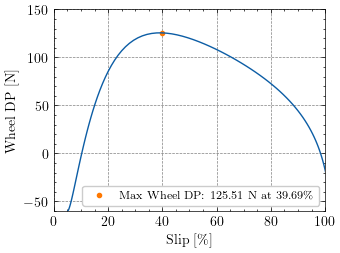

In [6]:

# Find the index of the maximum torque
max_dp_index = np.argmax(drawbar_pull)
max_dp_value = drawbar_pull[max_dp_index]/n_wheel
max_dp_slip = slip[max_dp_index]*100
plt.plot(max_dp_slip, max_dp_value, 'o', color=(255/255, 120/255, 0/255), markersize=3)
plt.plot(slip*100, drawbar_pull/n_wheel)
plt.xlabel('Slip [\%]')
plt.ylabel('Wheel DP [N]')
plt.xlim(0, 100)
plt.ylim(min(drawbar_pull/n_wheel), 150)
plt.legend([f'Max Wheel DP: {max_dp_value:.2f} N at {max_dp_slip:.2f}$\%$'], loc='lower right', fontsize='small')
plt.savefig("max_drawbar_pull_slip.pdf")
plt.savefig("max_drawbar_pull_slip.png")
plt.show()

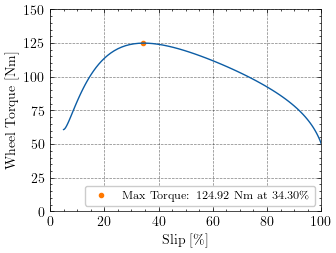

In [7]:
# Find the index of the maximum torque
max_torque_index = np.argmax(torque)
max_torque_value = torque[max_torque_index]
max_torque_slip = slip[max_torque_index]*100
plt.plot(max_torque_slip, max_torque_value, 'o', color=(255/255, 120/255, 0/255), markersize=3)
plt.plot(slip*100, torque)
plt.xlabel('Slip [\%]')
plt.ylabel('Wheel Torque [Nm]')
plt.xlim(0, 100)
plt.ylim(0, 150)
plt.legend([f'Max Torque: {max_torque_value:.2f} Nm at {max_torque_slip:.2f}$\%$'], loc='lower right', fontsize='small')
plt.savefig("max_torque_slip.pdf")
plt.savefig("max_torque_slip.png")
plt.show()

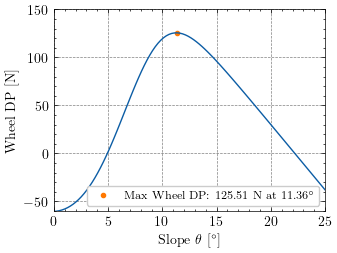

In [8]:
# Find the index of the maximum torque
max_dp_index = np.argmax(drawbar_pull)
max_dp_value = drawbar_pull[max_dp_index]/n_wheel
max_dp_theta = slope[max_dp_index]
plt.plot(max_dp_theta, max_dp_value, 'o', color=(255/255, 120/255, 0/255), markersize=3)
plt.plot(slope, drawbar_pull/n_wheel)
plt.xlabel('Slope $\\theta$ [$^\circ$]')
plt.ylabel('Wheel DP [N]')
plt.xlim(0, 25)
plt.ylim(min(drawbar_pull/n_wheel), 150)
plt.legend([f'Max Wheel DP: {max_dp_value:.2f} N at {max_dp_theta:.2f}$^\circ$'], loc='lower right', fontsize='small')
plt.savefig("max_drawbar_pull_slope.pdf")
plt.savefig("max_drawbar_pull_slope.png")
plt.show()

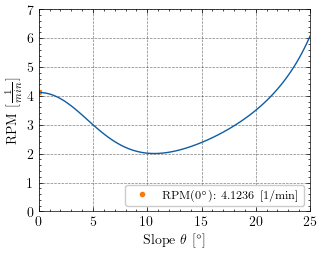

In [9]:
plt.plot(0, rpm[0], 'o', color=(255/255, 120/255, 0/255), markersize=3)
plt.plot(slope, rpm)
plt.xlabel('Slope $\\theta$ [$^\circ$]')
plt.ylabel('RPM [$\\frac{1}{min}$]')
plt.xlim(0,25)
plt.ylim(0,7)
plt.legend([f'RPM($0^\circ$): {rpm[0]:.4f} [1/min]'], loc='lower right', fontsize='small')
plt.savefig("max_rpm_slope.pdf")
plt.savefig("max_rpm_slope.png")
plt.show()

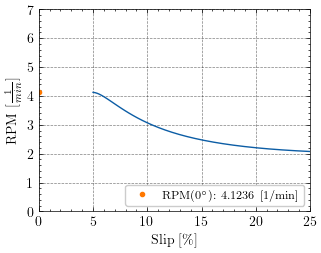

In [10]:
plt.plot(0, rpm[0], 'o', color=(255/255, 120/255, 0/255), markersize=3)
plt.plot(slip*100, rpm)
plt.xlabel('Slip [\%]')
plt.ylabel('RPM [$\\frac{1}{min}$]')
plt.xlim(0,25)
plt.ylim(0,7)
plt.legend([f'RPM($0^\circ$): {rpm[0]:.4f} [1/min]'], loc='lower right', fontsize='small')
plt.savefig("max_rpm_slip.pdf")
plt.savefig("max_rpm_slip.png")
plt.show()

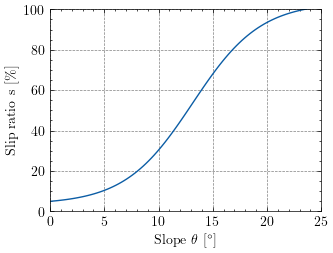

In [11]:
plt.plot(slope, slip*100)
plt.xlabel('Slope $\\theta$ [$^\circ$]')
plt.ylabel('Slip ratio s [\%]')
plt.xlim(0, 25)
plt.ylim(0, 100)
plt.savefig("sigmoid_slip.pdf")
plt.savefig("sigmoid_slip.png")
plt.show()

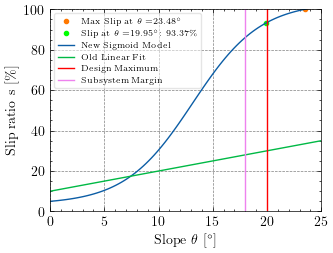

In [12]:
max_s_index = np.argmax(np.clip(slip, 0, 1))
max_s_value = slip[max_s_index]
max_s_slope = slope[max_s_index]

plt.plot(max_s_slope, max_s_value*100, 'o', color=(255/255, 120/255, 0/255), markersize=3, label=f'Max Slip at $\\theta=${max_s_slope:.2f}$^\circ$')

# Find the index of the slope closest to 20 degrees
design_s_index = np.abs(slope - 20).argmin()
design_s_slope = slope[design_s_index]
design_s_value = slip[design_s_index]

plt.plot(design_s_slope, design_s_value*100, 'o', color='lime', markersize=3, label=f'Slip at $\\theta=${design_s_slope:.2f}$^\circ$: {design_s_value*100:.2f}$\\%$')

plt.plot(slope, slip*100, label='New Sigmoid Model')
plt.plot(slope, slip_old*100, label='Old Linear Fit')
plt.plot(np.linspace(20, 20, len(slope)), np.linspace(0, 100, len(slope)), color='red', label='Design Maximum')
plt.plot(np.linspace(18, 18, len(slope)), np.linspace(0, 100, len(slope)), color='violet', label='Subsystem Margin')
plt.xlabel('Slope $\\theta$ [$^\circ$]')
plt.ylabel('Slip ratio s [\%]')
plt.xlim(0, 25)
plt.ylim(0, 100)
plt.legend(fancybox=True, framealpha=0.5, loc='best', fontsize='6')
plt.savefig("sigmoid_slip_comparison.pdf")
plt.savefig("sigmoid_slip_comparison.png")
plt.show()

In [13]:
def func(slope, v_rover_constant, mass, diameter, power_constant, b_width, gravity, h_grouser, n_grouser):
    n_wheel = 4 # number of wheels
    #diameter = 0.8
    radius = diameter/2
    #b_width = 0.35 # wheel width in m
    #h_grouser = 0.03 # grouser height
    #n_grouser = 8 # number of grousers
    eta = 0.7 # gearbox efficiency
    #power_constant = 150*eta # constant power for the whole locomotion subsystem
    #v_rover_constant = 0.05 # km/h
    c_b = 170 # N/m^2 coefficient of soil/wheel cohesion
    n = 1 # exponent of soil deformation
    k_c = 1400 # N/m^2 cohesive modulus of soil deformation
    k_phi = 830000  # N/m^3 frictional modulus of soil deformation
    K = 0.018  # coefficient of soil slip in m
    gamma = 2470 # N/m3 lunar soil density
    phi = 33 # deg soil internal friction angle
    phi_rad = np.deg2rad(phi) # rad soil internal friction angle
    mu = np.tan(phi_rad) # static friction coefficient
    N_q = 32.23
    N_c = 48.09
    N_gamma = 33.27
    K_c = 33.37
    K_phi = 72.77
    K_gamma = 81.93
    #mass = 1800 # mass of the rover
    #gravity = 1.62 # gravitational constant of the moon
    #slope = np.linspace(0, 25, 100)
    #slope = 0
    slip = 0.0353 + 1/(1+67*np.exp(-0.32*slope))
    #slip = 1
    k = (k_c / b_width) + k_phi
    c_f = 0.05 # internal rolling friction coefficient (bearings)

    W_vehicle = mass * gravity
    W_vehicle_normal = W_vehicle * np.cos(np.deg2rad(slope))
    W_wheel = mass * gravity / n_wheel
    W_wheel_normal = W_wheel * np.cos(np.deg2rad(slope))

    z_sinkage = (3 * W_wheel_normal / ((3 - n) * (k_c + b_width * k_phi) * np.sqrt(diameter))) ** (2/(2*n+1))
    pressure = k * z_sinkage ** n

    theta_1 = np.arccos(1 - z_sinkage / radius)
    theta_m = (0.45 + 0.24 * slip) * theta_1
    lever_e = radius * np.sin(theta_1 - theta_m)
    lever_l = radius * np.cos(theta_1 - theta_m)
    l_contact = (diameter / 2) * np.arccos(1 - (2 * z_sinkage / diameter))
    A = b_width * l_contact
    alpha = np.arccos(1 - 2 * z_sinkage / diameter) # angle of approach
    l_0 = z_sinkage * np.tan(np.pi / 4 - phi_rad / 2) ** 2 # distance of rupture

    R_compression = ((b_width * k) / (n+1)) * z_sinkage ** (n+1)
    R_bulldozing = (b_width*np.sin(alpha+phi_rad) / (2*np.sin(alpha)*np.cos(phi_rad))) * (2*z_sinkage*c_b*K_c + gamma*K_gamma*z_sinkage**2) + ((gamma*l_0**3)/3) * (np.pi/2 - phi_rad) + (c_b*l_0**2) * (1+np.tan(np.pi/4 + phi_rad/2))
    R_gravitational = W_wheel * np.sin(np.deg2rad(slope))
    R_rolling = W_wheel_normal * c_f # internal (bearings)

    sum_R = 4* R_compression + 2* R_bulldozing + 4* R_gravitational + 4* R_rolling
    n_grouser_contact = 2 * np.pi * radius / (n_grouser * l_contact)

    sum_H_grouser = 4* (A*c_b*(1+2*h_grouser/b_width)*n_grouser_contact + W_wheel_normal*mu*(1 + (0.64*h_grouser/b_width) * np.arctan(b_width/h_grouser))) * (1-np.exp(-slip * l_contact / K))

    W_wheel_safe = A * (c_b*N_c + gamma*z_sinkage*N_q + gamma*b_width*N_gamma/2)
    pressure_soil_safe = W_wheel_safe / A
    pressure_real = W_wheel / A
    pressure_margin = pressure_real / pressure_soil_safe
    weight_margin = W_wheel / W_wheel_safe

    drawbar_pull = sum_H_grouser - sum_R
    torque = (((drawbar_pull * lever_l) + (W_vehicle_normal * lever_e))/n_wheel) + 28
    omega = power_constant / (torque * n_wheel)
    rpm = omega * 60/ (2 * np.pi)
    v_rover = omega * radius * 3.6 * (1-slip)
    power_variable = (v_rover_constant * torque * n_wheel) / (radius * 3.6 * (1-slip))
    power_variable_step = np.clip(50 * np.ceil(np.clip(power_variable,30,100) / 30), 50, 100)
    return v_rover, power_variable, power_variable_step, drawbar_pull, torque, rpm, pressure, pressure_soil_safe, pressure_real

In [14]:
data = pd.read_csv('Pfad_komplett_Steigung_V2.csv')
distance = data['position']
longitude = -data['lon']
latitude = -data['lat']
slope = data['TerrainSlope']

data['position_difference'] = data['position'].diff()
data['slope_difference'] = data['TerrainSlope'].diff()

solution = func(slope, v_rover_constant, mass, diameter, power_constant, b_width, gravity, h_grouser, n_grouser)
data['velocity'] = solution[0]

data['weighted_velocity'] = data['position_difference'] * data['velocity']
data['weighted_slope'] = data['position_difference'] * data['TerrainSlope']

mean_velocity = data['weighted_velocity'].sum() / data['position_difference'].sum()
mean_slope = data['weighted_slope'].sum() / data['position_difference'].sum()

end_distance = data['position'].iloc[-1]
data['time'] =  data['position'].diff().sum() / (data['weighted_velocity'].sum() / data['position_difference'].sum())
total_time = end_distance / mean_velocity

print("Mean Velocity: {:.4f} km/h".format(mean_velocity))
print("Mean Slope: {:.4f} °".format(mean_slope))
print("End Distance: {:.4f} km".format(end_distance))
print("Total Time: {:.4f} h".format(total_time))

Mean Velocity: 0.4048 km/h
Mean Slope: 5.3480 °
End Distance: 128.4204 km
Total Time: 317.2371 h


In [15]:
v_rover_constant = distance.iloc[-1] / ((0.5 - 0.25) * 365 * 24)
v_rover_constant

0.058639446575342466

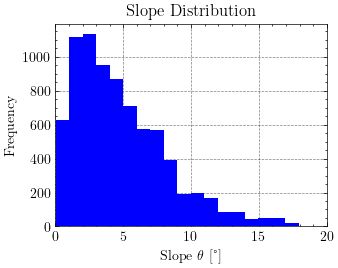

In [16]:
plt.hist(slope, bins=18, density=False, color='b')

# Add labels and title
plt.xlabel('Slope $\\theta$ [°]')
plt.ylabel('Frequency')
plt.xlim(0, 20)
plt.title('Slope Distribution')
plt.savefig("slope_histogram.pdf")
plt.savefig("slope_histogram.png")
# Show the plot
plt.show()

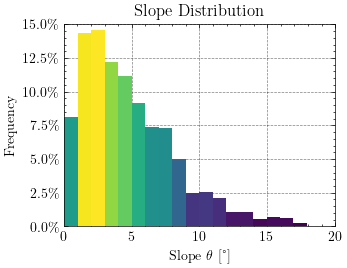

In [17]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# Number of bins
n_bins = 18 #*2

# First subplot: Color-coded histogram
N, bins, patches = plt.hist(slope, bins=n_bins, density=True)

# Normalize the data for color-coding
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

# Loop through patches and set color based on height
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# Add labels and title
plt.xlabel('Slope $\\theta$ [°]')
plt.ylabel('Frequency')
plt.xlim(0, 20)
plt.ylim(0, 0.15)
plt.title('Slope Distribution')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig("slope_histogram_color.pdf")
plt.savefig("slope_histogram_color.png")
plt.show()

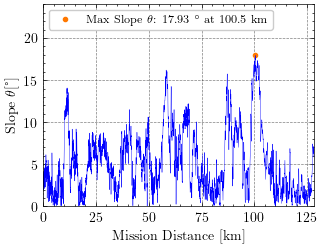

In [18]:
max_slope_index = np.argmax(slope)
max_slope_value = slope[max_slope_index]
max_slope_distance = distance[max_slope_index]
plt.plot(max_slope_distance, max_slope_value, 'o', color=(255/255, 120/255, 0/255), markersize=3)
plt.plot(distance, slope, color='b', linewidth=0.3)

plt.xlabel('Mission Distance [km]')
plt.ylabel('Slope $\\theta$[°]')
plt.xlim(0, distance.iloc[-1])
plt.ylim(0, 24)
plt.legend([f'Max Slope $\\theta$: {max_slope_value:.2f} $^\circ$ at {max_slope_distance:.1f} km'], loc='upper left', fontsize='small')
plt.savefig("mission_distance_slope.pdf")
plt.savefig("mission_distance_slope.png")
plt.show()

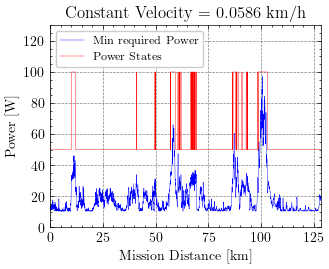

In [19]:
plt.plot(distance, func(slope, v_rover_constant, 1800, 0.8, 150*0.7, 0.35, 1.62, 0.03, 8)[1],color='b', linewidth=0.3, label='Min required Power')
plt.plot(distance, func(slope, v_rover_constant, 1800, 0.8, 150*0.7, 0.35, 1.62, 0.03, 8)[2], color='red',  linewidth=0.3, label='Power States')
plt.xlabel('Mission Distance [km]')
plt.ylabel('Power [W]')
plt.xlim(0, distance.iloc[-1])
plt.ylim(0, 130)
plt.title('Constant Velocity = {:.4f} km/h'.format(v_rover_constant))
plt.legend(loc='upper left', fontsize='small')
plt.savefig("rover_power_over_mission_distance.pdf")
plt.savefig("rover_power_over_mission_distance.png")
plt.show()

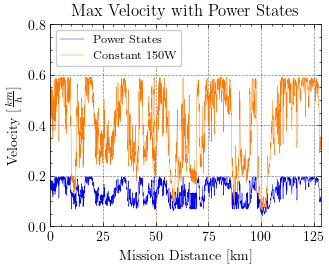

In [20]:
power_states = func(slope, v_rover_constant, 1800, 0.8, 150*0.7, 0.35, 1.62, 0.03, 8)[2]
plt.plot(distance, func(slope, v_rover_constant, 1800, 0.8, power_states*0.7, 0.35, 1.62, 0.03, 8)[0], color='b',  linewidth=0.3, label='Power States')
plt.plot(distance, func(slope, v_rover_constant, 1800, 0.8, 150*0.7, 0.35, 1.62, 0.03, 8)[0], color=(255/255, 120/255, 0/255), linewidth=0.3, label='Constant 150W')
plt.xlabel('Mission Distance [km]')
plt.ylabel('Velocity [$\\frac{km}{h}$]')
plt.xlim(0, distance.iloc[-1])
plt.ylim(0, 0.8)
plt.title('Max Velocity with Power States')
plt.legend(loc='upper left', fontsize='small')
plt.savefig("power_states_over_mission_distance.pdf")
plt.savefig("power_states_over_mission_distance.png")
plt.show()

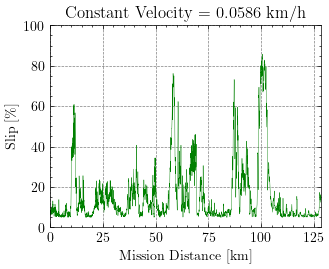

In [21]:
slip = 0.0353 + 1/(1+67*np.exp(-0.32*slope))
plt.plot(distance, slip*100, linewidth=0.3, color='green')
plt.xlabel('Mission Distance [km]')
plt.ylabel('Slip [\%]')
plt.xlim(0, distance.iloc[-1])
plt.ylim(0, 100)
plt.title('Constant Velocity = {:.4f} km/h'.format(v_rover_constant))
plt.savefig("slip_over_mission_distance.pdf")
plt.savefig("slip_over_mission_distance.png")
plt.show()

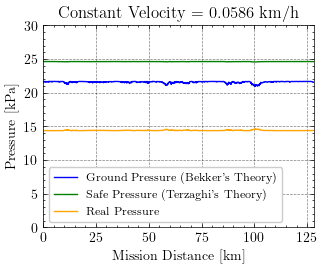

In [22]:
plt.plot(distance, func(slope, v_rover_constant, 1800, 0.8, 150*0.7, 0.35, 1.62, 0.03, 8)[6]/1000, color='blue', linewidth=1, label='Ground Pressure (Bekker\'s Theory)')
plt.plot(distance, func(slope, v_rover_constant, 1800, 0.8, 150*0.7, 0.35, 1.62, 0.03, 8)[7]/1000, color='green', linewidth=1, label='Safe Pressure (Terzaghi\'s Theory)')
plt.plot(distance, func(slope, v_rover_constant, 1800, 0.8, 150*0.7, 0.35, 1.62, 0.03, 8)[8]/1000, color='orange', linewidth=1, label='Real Pressure')
plt.xlabel('Mission Distance [km]')
plt.ylabel('Pressure [kPa]')
plt.xlim(0, distance.iloc[-1])
plt.ylim(0, 30)
plt.title('Constant Velocity = {:.4f} km/h'.format(v_rover_constant))
plt.legend(fontsize='small')
plt.savefig("pressure_over_mission_distance.pdf")
plt.savefig("pressure_over_mission_distance.png")
plt.show()

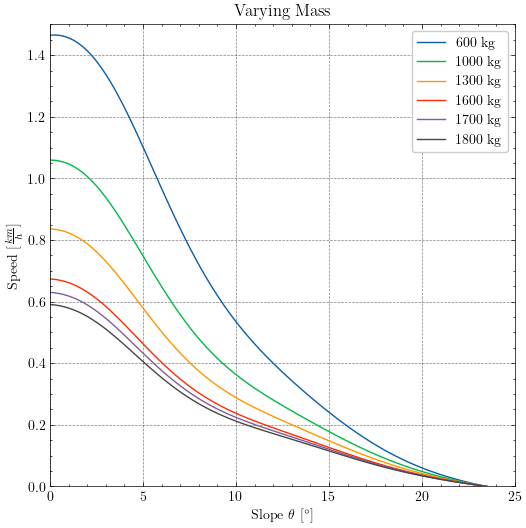

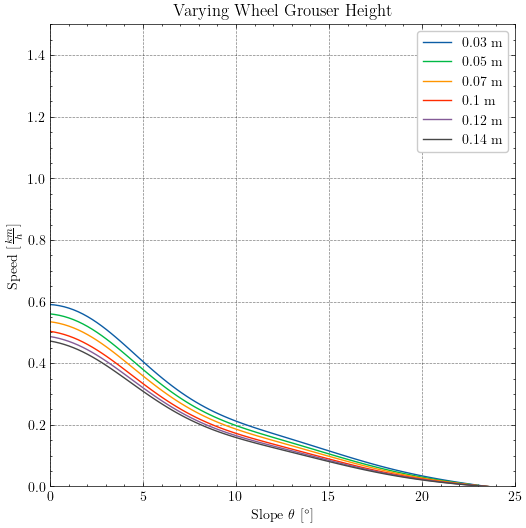

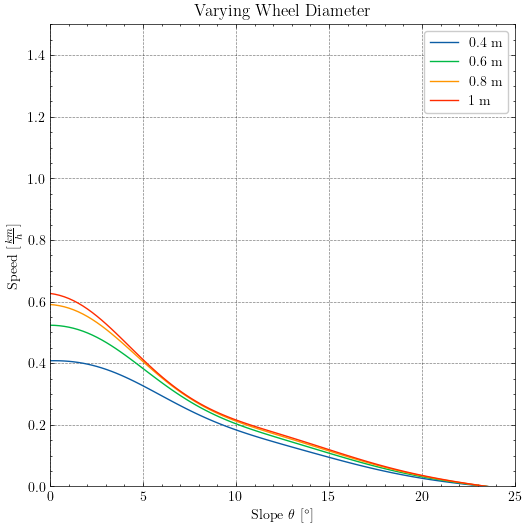

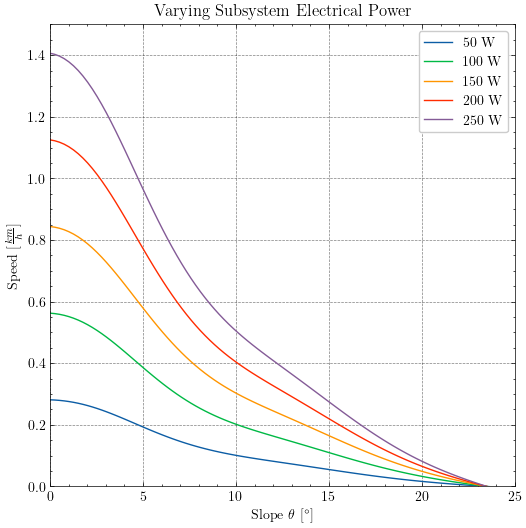

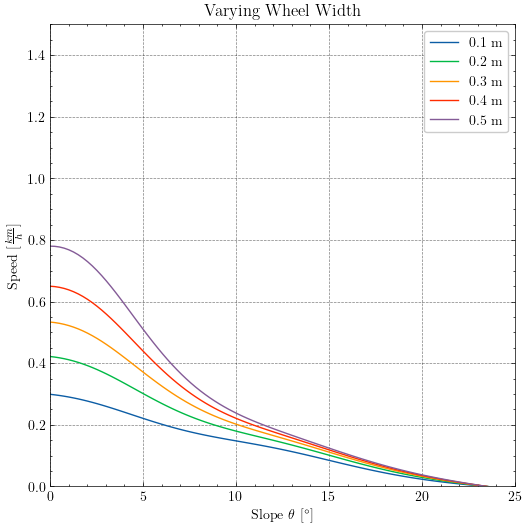

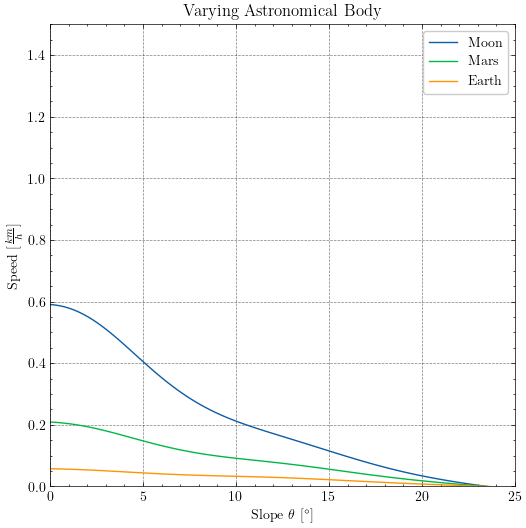

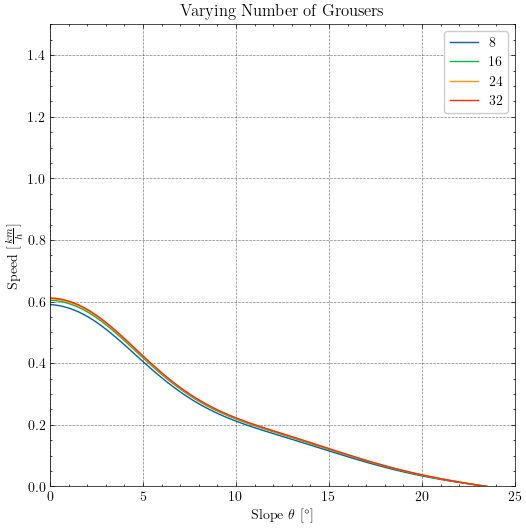

In [23]:
slope = np.linspace(0, 25, 100) # range of slope values

# Define values for mass, slip, radius, and power
mass_values = [600, 1000, 1300, 1600, 1700, 1800]
h_grouser_values = [0.03, 0.05, 0.07, 0.1, 0.12, 0.14]
diameter_values = [0.4, 0.6, 0.8, 1]
power_values = [ 50, 100, 150, 200, 250]
width_values = [0.1, 0.2, 0.3, 0.4, 0.5]
gravity_values = [1.62, 3.71, 9.81]
gravity_name_values = ['Moon', 'Mars', 'Earth']
n_grouser_values = [8, 16, 24, 32]

# Create subplots for Varying Mass
fig1, ax1 = plt.subplots(figsize=(6, 6))
for mass_n in mass_values:
    ax1.plot(slope, func(slope, v_rover_constant, mass_n, diameter, power_constant, b_width, gravity, h_grouser, n_grouser)[0], label=f"{mass_n} kg")
ax1.legend()
ax1.set_title("Varying Mass")
ax1.set_xlabel('Slope $\\theta$ [$^\circ$]')
ax1.set_ylabel('Speed [$\\frac{km}{h}$]')
ax1.set_xlim(0, 25)
ax1.set_ylim(0, 1.5)
plt.savefig("tire_sim_varying_mass.pdf")
plt.savefig("tire_sim_varying_mass.png")
plt.show()

# Create subplots for Varying Grouser Height
fig2, ax2 = plt.subplots(figsize=(6, 6))
for h_grouser_n in h_grouser_values:
    ax2.plot(slope, func(slope, v_rover_constant, mass, diameter, power_constant, b_width, gravity, h_grouser_n, n_grouser)[0], label=f"{h_grouser_n} m")
ax2.legend()
ax2.set_title("Varying Wheel Grouser Height")
ax2.set_xlabel('Slope $\\theta$ [$^\circ$]')
ax2.set_ylabel('Speed [$\\frac{km}{h}$]')
ax2.set_xlim(0, 25)
ax2.set_ylim(0, 1.5)
plt.savefig("tire_sim_varying_grouser_height.pdf")
plt.savefig("tire_sim_varying_grouser_height.png")
plt.show()

# Create subplots for Varying Radius
fig3, ax3 = plt.subplots(figsize=(6, 6))
for diameter_n in diameter_values:
    ax3.plot(slope, func(slope, v_rover_constant, mass, diameter_n, power_constant, b_width, gravity, h_grouser, n_grouser)[0], label=f"{diameter_n} m")
ax3.legend()
ax3.set_title("Varying Wheel Diameter")
ax3.set_xlabel('Slope $\\theta$ [$^\circ$]')
ax3.set_ylabel('Speed [$\\frac{km}{h}$]')
ax3.grid(True)
ax3.set_xlim(0, 25)
ax3.set_ylim(0, 1.5)
plt.savefig("tire_sim_varying_diameter.pdf")
plt.savefig("tire_sim_varying_diameter.png")
plt.show()

# Create subplots for Varying Power
fig4, ax4 = plt.subplots(figsize=(6, 6))
for power_n in power_values:
    ax4.plot(slope, func(slope, v_rover_constant, mass, diameter, power_n, b_width, gravity, h_grouser, n_grouser)[0], label=f"{power_n} W")
ax4.legend()
ax4.set_title("Varying Subsystem Electrical Power")
ax4.set_xlabel('Slope $\\theta$ [$^\circ$]')
ax4.set_ylabel('Speed [$\\frac{km}{h}$]')
ax4.grid(True)
ax4.set_xlim(0, 25)
ax4.set_ylim(0, 1.5)
plt.savefig("tire_sim_varying_power.pdf")
plt.savefig("tire_sim_varying_power.png")
plt.show()

# Create subplots for Varying Width
fig5, ax5 = plt.subplots(figsize=(6, 6))
for width_n in width_values:
    ax5.plot(slope, func(slope, v_rover_constant, mass, diameter, power_constant, width_n, gravity, h_grouser, n_grouser)[0], label=f"{width_n} m")
ax5.legend()
ax5.set_title("Varying Wheel Width")
ax5.set_xlabel('Slope $\\theta$ [$^\circ$]')
ax5.set_ylabel('Speed [$\\frac{km}{h}$]')
ax5.set_xlim(0, 25)
ax5.set_ylim(0, 1.5)
plt.savefig("tire_sim_varying_width.pdf")
plt.savefig("tire_sim_varying_width.png")
plt.show()

# Create subplots for Varying Planet
fig6, ax6 = plt.subplots(figsize=(6, 6))

for gravity_val, gravity_name in zip(gravity_values, gravity_name_values):
    ax6.plot(slope, func(slope, v_rover_constant, mass, diameter, power_constant, b_width, gravity_val, h_grouser, n_grouser)[0], label=f"{gravity_name}")
ax6.legend()
ax6.set_title("Varying Astronomical Body")
ax6.set_xlabel('Slope $\\theta$ [$^\circ$]')
ax6.set_ylabel('Speed [$\\frac{km}{h}$]')
ax6.set_xlim(0, 25)
ax6.set_ylim(0, 1.5)
plt.savefig("tire_sim_varying_gravity.pdf")
plt.savefig("tire_sim_varying_gravity.png")
plt.show()

# Create subplots for Varying Number of Grousers
fig5, ax7 = plt.subplots(figsize=(6, 6))
for n_grouser_n in n_grouser_values:
    ax7.plot(slope, func(slope, v_rover_constant, mass, diameter, power_constant, b_width, gravity, h_grouser, n_grouser_n)[0], label=f"{n_grouser_n}")
ax7.legend()
ax7.set_title("Varying Number of Grousers")
ax7.set_xlabel('Slope $\\theta$ [$^\circ$]')
ax7.set_ylabel('Speed [$\\frac{km}{h}$]')
ax7.set_xlim(0, 25)
ax7.set_ylim(0, 1.5)
plt.savefig("tire_sim_varying_number_of_grousers.pdf")
plt.savefig("tire_sim_varying_number_of_grousers.png")
plt.show()

In [24]:
slope = np.linspace(0, 20, 100)
solution = func(slope, v_rover_constant, 1800, 0.8, 150*0.7, 0.35, 1.62, 0.03, 8)
# Calculate required values
slope_min, slope_min, slope_max = np.min(slope), np.mean(slope), np.max(slope)
drawbar_pull_min, drawbar_pull_mean, drawbar_pull_max = np.min(solution[3]), np.mean(solution[3]), np.max(solution[3])
v_min, v_mean, v_max = np.min(solution[0]), np.mean(solution[0]), np.max(solution[0])
torque_min, torque_mean, torque_max = np.min(solution[4]), np.mean(solution[4]), np.max(solution[4])
P_min, P_mean, P_max = np.min(solution[1]), np.mean(solution[1]), np.max(solution[1])
rpm_min, rpm_mean, rpm_max = np.min(solution[5]), np.mean(solution[5]), np.max(solution[5])

# Print optimized results with \n after each value
print(f"slope_min: {slope_min:.2f}\nslope_mean: {slope_min:.2f}\nslope_max: {slope_max:.2f}\n"
      f"drawbar_pull_min: {drawbar_pull_min:.2f}\ndrawbar_pull_mean: {drawbar_pull_mean:.2f}\ndrawbar_pull_max: {drawbar_pull_max:.2f}\n"
      f"v_min: {v_min:.4f}\nv_mean: {v_mean:.4f}\nv_max: {v_max:.4f}\n"
      f"torque_min: {torque_min:.2f}\ntorque_mean: {torque_mean:.2f}\ntorque_max: {torque_max:.2f}\n"
      f"P_min: {P_min:.2f}\nP_mean: {P_mean:.2f}\nP_max: {P_max:.2f}\n"
      f"rpm_min: {rpm_min:.4f}\nrpm_mean: {rpm_mean:.4f}\nrpm_max: {rpm_max:.4f}")

slope_min: 10.00
slope_mean: 10.00
slope_max: 20.00
drawbar_pull_min: -241.65
drawbar_pull_mean: 204.78
drawbar_pull_max: 502.09
v_min: 0.0343
v_mean: 0.2629
v_max: 0.5907
torque_min: 60.79
torque_mean: 95.06
torque_max: 124.91
P_min: 10.42
P_mean: 42.84
P_max: 179.56
rpm_min: 2.0067
rpm_mean: 2.7850
rpm_max: 4.1236


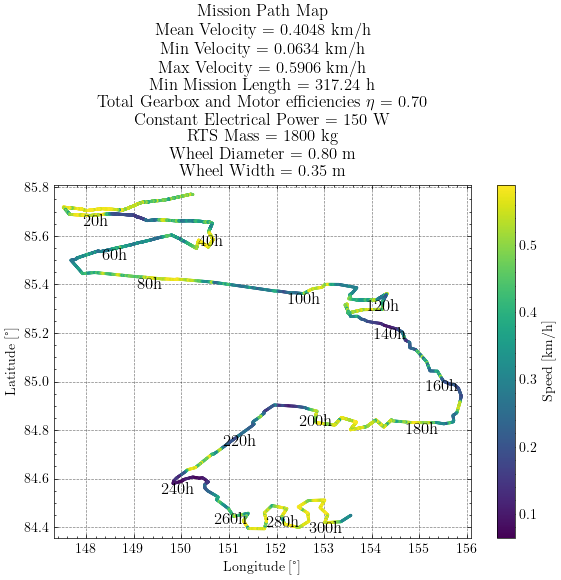

In [25]:
from scipy.interpolate import griddata
data = pd.read_csv('Pfad_komplett_Steigung_V2.csv')

distance = data['position']
longitude = -data['lon']
latitude = -data['lat']
slope = data['TerrainSlope']

# Create a grid spherical
#xi_sphere = np.linspace(min(longitude), max(longitude), len(longitude))
#yi_sphere = np.linspace(min(latitude), max(latitude), len(latitude))
#xi_sphere, yi_sphere = np.meshgrid(xi_sphere, yi_sphere)
#zi_sphere = griddata((longitude, latitude), slope, (xi_sphere, yi_sphere), method='nearest')

solution = func(slope, v_rover_constant, 1800, 0.8, 150*0.7, 0.35, 1.62, 0.03, 8)
end_distance = distance.iloc[-1]
v_min = np.min(solution[0])
v_max = np.max(solution[0])

data['position_difference'] = data['position'].diff()
data['velocity'] = solution[0]
data['weighted_velocity'] = data['position_difference'] * data['velocity']

mean_velocity = data['weighted_velocity'].sum() / data['position_difference'].sum()
slope_mean = np.mean(data['TerrainSlope'])
end_distance = data['position'].iloc[-1]
total_time = end_distance / mean_velocity

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
#contour1 = ax1.contourf(xi_sphere, yi_sphere, zi_sphere, cmap='viridis')
#fig.colorbar(contour1, ax=ax1, label='Terrain Slope [°]')
scatter1 = ax1.scatter(longitude, latitude, c=solution[0], marker='.', s=5, cmap='viridis')
fig.colorbar(scatter1, ax=ax1, label='Speed [km/h]')
ax1.axis('auto')
margin = 0.2
ax1.set_xlim(min(longitude) - margin, max(longitude) + margin)
ax1.set_ylim(min(latitude) - margin/5, max(latitude) + margin/5)

# Add markers for every k hours
k = 20  # hours
tolerance = 0.1  # Adjust this value based on your desired tolerance
marker_added = False  # Reset the marker flag at the start

for i in range(len(distance)):
    if i > 0:
        v_mean_up_to = np.cumsum(data['weighted_velocity'] / data['position_difference'])[i] / i
        time_passed = distance[i] / v_mean_up_to
        # Check if the current time_passed is within a new k-hour interval
        if abs((time_passed % k) / k - 1) < tolerance and not marker_added:
            label_text = '{}h'.format(round(time_passed / k) * k)
            #ax1.plot(longitude[i], latitude[i], 'o', color='white', markersize=6, markeredgecolor='black')
            ax1.text(longitude[i], latitude[i], label_text, ha='center', va='top', color='black', fontsize=12, alpha=1)
            marker_added = True  # Set the flag to True after adding the marker and label
        elif abs((time_passed % k) / k - 1) >= tolerance:
            marker_added = False  # Reset the flag if outside the tolerance

ax1.set_xlabel('Longitude [°]')
ax1.set_ylabel('Latitude [°]')
ax1.set_title('Mission Path Map\n'
              'Mean Velocity = {:.4f} km/h\n'
              'Min Velocity = {:.4f} km/h\n'
              'Max Velocity = {:.4f} km/h\n'
              'Min Mission Length = {:.2f} h\n'
              'Total Gearbox and Motor efficiencies $\\eta$ = {:.2f}\n'
              'Constant Electrical Power = {:.0f} W\n'
              'RTS Mass = {:.0f} kg\n'
              'Wheel Diameter = {:.2f} m\n'
              'Wheel Width = {:.2f} m'
              .format(mean_velocity, v_min, v_max, total_time, eta, power_constant/eta, mass, diameter, b_width))
plt.tight_layout()
plt.savefig("map_constant_power_variable_velocity.pdf")
plt.savefig("map_constant_power_variable_velocity.png")
plt.show()

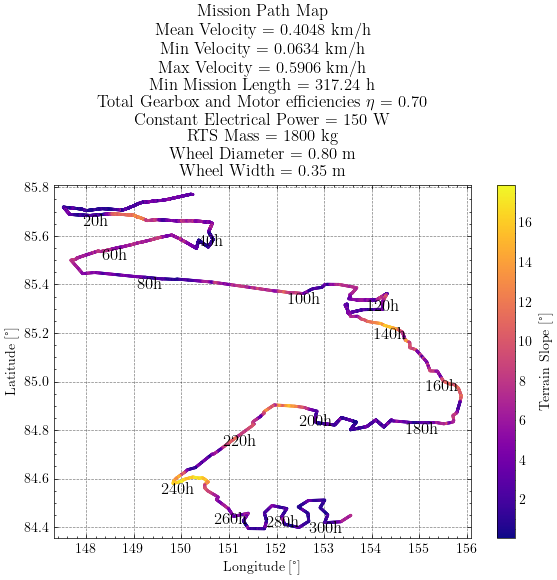

In [26]:
from scipy.interpolate import griddata
data = pd.read_csv('Pfad_komplett_Steigung_V2.csv')

distance = data['position']
longitude = -data['lon']
latitude = -data['lat']
slope = data['TerrainSlope']

# Create a grid spherical
#xi_sphere = np.linspace(min(longitude), max(longitude), len(longitude))
#yi_sphere = np.linspace(min(latitude), max(latitude), len(latitude))
#xi_sphere, yi_sphere = np.meshgrid(xi_sphere, yi_sphere)
#zi_sphere = griddata((longitude, latitude), slope, (xi_sphere, yi_sphere), method='nearest')

solution = func(slope, v_rover_constant, 1800, 0.8, 150*0.7, 0.35, 1.62, 0.03, 8)
end_distance = distance.iloc[-1]
v_min = np.min(solution[0])
v_max = np.max(solution[0])

data['position_difference'] = data['position'].diff()
data['velocity'] = solution[0]
data['weighted_velocity'] = data['position_difference'] * data['velocity']

mean_velocity = data['weighted_velocity'].sum() / data['position_difference'].sum()
slope_mean = np.mean(data['TerrainSlope'])
end_distance = data['position'].iloc[-1]
total_time = end_distance / mean_velocity

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
scatter1 = ax1.scatter(longitude, latitude, c=slope, marker='.', s=5, cmap='plasma')
fig.colorbar(scatter1, ax=ax1, label='Terrain Slope [°]')
#scatter1 = ax1.scatter(longitude, latitude, c=solution[0], linewidths=0.1, marker='o', s=5, cmap='viridis')
#fig.colorbar(scatter1, ax=ax1, label='Speed [km/h]')
ax1.axis('auto')
margin = 0.2
ax1.set_xlim(min(longitude) - margin, max(longitude) + margin)
ax1.set_ylim(min(latitude) - margin/5, max(latitude) + margin/5)

# Add markers for every k hours
k = 20  # hours
tolerance = 0.1  # Adjust this value based on your desired tolerance
marker_added = False  # Reset the marker flag at the start

for i in range(len(distance)):
    if i > 0:
        v_mean_up_to = np.cumsum(data['weighted_velocity'] / data['position_difference'])[i] / i
        time_passed = distance[i] / v_mean_up_to
        # Check if the current time_passed is within a new k-hour interval
        if abs((time_passed % k) / k - 1) < tolerance and not marker_added:
            label_text = '{}h'.format(round(time_passed / k) * k)
            #ax1.plot(longitude[i], latitude[i], 'o', color='white', markersize=6, markeredgecolor='black')
            ax1.text(longitude[i], latitude[i], label_text, ha='center', va='top', color='black', fontsize=12, alpha=1)
            marker_added = True  # Set the flag to True after adding the marker and label
        elif abs((time_passed % k) / k - 1) >= tolerance:
            marker_added = False  # Reset the flag if outside the tolerance

ax1.set_xlabel('Longitude [°]')
ax1.set_ylabel('Latitude [°]')
ax1.set_title('Mission Path Map\n'
              'Mean Velocity = {:.4f} km/h\n'
              'Min Velocity = {:.4f} km/h\n'
              'Max Velocity = {:.4f} km/h\n'
              'Min Mission Length = {:.2f} h\n'
              'Total Gearbox and Motor efficiencies $\\eta$ = {:.2f}\n'
              'Constant Electrical Power = {:.0f} W\n'
              'RTS Mass = {:.0f} kg\n'
              'Wheel Diameter = {:.2f} m\n'
              'Wheel Width = {:.2f} m'
              .format(mean_velocity, v_min, v_max, total_time, eta, power_constant/eta, mass, diameter, b_width))
plt.tight_layout()
plt.savefig("map_slope.pdf")
plt.savefig("map_slope.png")
plt.show()

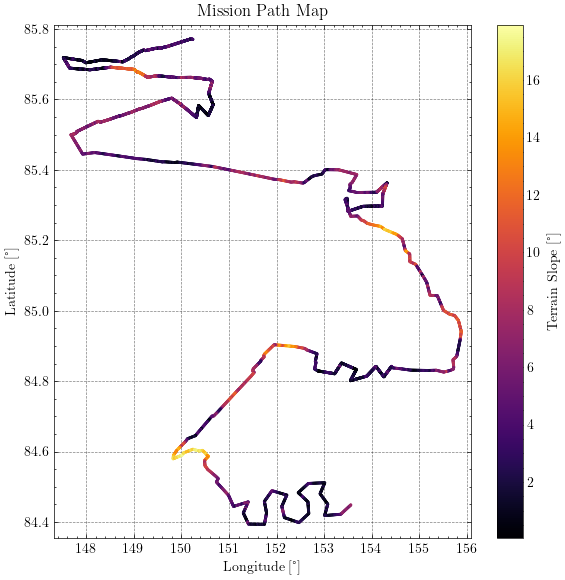

In [27]:
from scipy.interpolate import griddata
data = pd.read_csv('Pfad_komplett_Steigung_V2.csv')

distance = data['position']
longitude = -data['lon']
latitude = -data['lat']
slope = data['TerrainSlope']

# Create a grid spherical
#xi_sphere = np.linspace(min(longitude), max(longitude), len(longitude))
#yi_sphere = np.linspace(min(latitude), max(latitude), len(latitude))
#xi_sphere, yi_sphere = np.meshgrid(xi_sphere, yi_sphere)
#zi_sphere = griddata((longitude, latitude), slope, (xi_sphere, yi_sphere), method='nearest')

solution = func(slope, v_rover_constant, 1800, 0.8, 150*0.7, 0.35, 1.62, 0.03, 8)
end_distance = distance.iloc[-1]
v_min = np.min(solution[0])
v_max = np.max(solution[0])

data['position_difference'] = data['position'].diff()
data['velocity'] = solution[0]
data['weighted_velocity'] = data['position_difference'] * data['velocity']

mean_velocity = data['weighted_velocity'].sum() / data['position_difference'].sum()
slope_mean = np.mean(data['TerrainSlope'])
end_distance = data['position'].iloc[-1]
total_time = end_distance / mean_velocity

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
scatter1 = ax1.scatter(longitude, latitude, c=slope, marker='.', s=5, cmap='inferno')
fig.colorbar(scatter1, ax=ax1, label='Terrain Slope [°]')
#scatter1 = ax1.scatter(longitude, latitude, c=solution[0], linewidths=0.1, marker='o', s=5, cmap='viridis')
#fig.colorbar(scatter1, ax=ax1, label='Speed [km/h]')
ax1.axis('auto')
margin = 0.2
ax1.set_xlim(min(longitude) - margin, max(longitude) + margin)
ax1.set_ylim(min(latitude) - margin/5, max(latitude) + margin/5)

ax1.set_xlabel('Longitude [°]')
ax1.set_ylabel('Latitude [°]')
ax1.set_title('Mission Path Map')
plt.tight_layout()
plt.savefig("map_slope_sys_management.pdf")
plt.savefig("map_slope_sys_management.png")
plt.show()

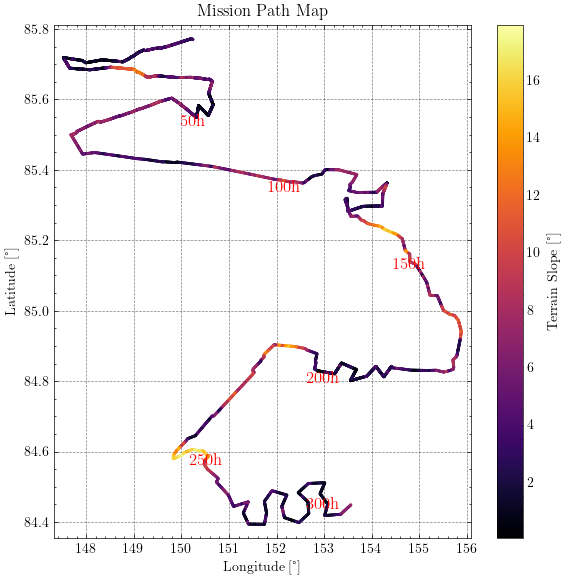

In [28]:
from scipy.interpolate import griddata
data = pd.read_csv('Pfad_komplett_Steigung_V2.csv')

distance = data['position']
longitude = -data['lon']
latitude = -data['lat']
slope = data['TerrainSlope']

# Create a grid spherical
#xi_sphere = np.linspace(min(longitude), max(longitude), len(longitude))
#yi_sphere = np.linspace(min(latitude), max(latitude), len(latitude))
#xi_sphere, yi_sphere = np.meshgrid(xi_sphere, yi_sphere)
#zi_sphere = griddata((longitude, latitude), slope, (xi_sphere, yi_sphere), method='nearest')

solution = func(slope, v_rover_constant, 1800, 0.8, 150*0.7, 0.35, 1.62, 0.03, 8)
end_distance = distance.iloc[-1]
v_min = np.min(solution[0])
v_max = np.max(solution[0])

data['position_difference'] = data['position'].diff()
data['velocity'] = solution[0]
data['weighted_velocity'] = data['position_difference'] * data['velocity']

mean_velocity = data['weighted_velocity'].sum() / data['position_difference'].sum()
slope_mean = np.mean(data['TerrainSlope'])
end_distance = data['position'].iloc[-1]
total_time = end_distance / mean_velocity

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
scatter1 = ax1.scatter(longitude, latitude, c=slope, marker='.', s=5, cmap='inferno')
fig.colorbar(scatter1, ax=ax1, label='Terrain Slope [°]')
#scatter1 = ax1.scatter(longitude, latitude, c=solution[0], linewidths=0.1, marker='o', s=5, cmap='viridis')
#fig.colorbar(scatter1, ax=ax1, label='Speed [km/h]')
ax1.axis('auto')
margin = 0.2
ax1.set_xlim(min(longitude) - margin, max(longitude) + margin)
ax1.set_ylim(min(latitude) - margin/5, max(latitude) + margin/5)

# Add markers for every k hours
k = 50  # hours
tolerance = 0.1  # Adjust this value based on your desired tolerance
marker_added = False  # Reset the marker flag at the start

for i in range(len(distance)):
    if i > 0:
        v_mean_up_to = np.cumsum(data['weighted_velocity'] / data['position_difference'])[i] / i
        time_passed = distance[i] / v_mean_up_to
        # Check if the current time_passed is within a new k-hour interval
        if abs((time_passed % k) / k - 1) < tolerance and not marker_added:
            label_text = '{}h'.format(round(time_passed / k) * k)
            #ax1.plot(longitude[i], latitude[i], 'o', color='white', markersize=6, markeredgecolor='black')
            ax1.text(longitude[i], latitude[i], label_text, ha='center', va='top', color='red', fontsize=12, alpha=1)
            marker_added = True  # Set the flag to True after adding the marker and label
        elif abs((time_passed % k) / k - 1) >= tolerance:
            marker_added = False  # Reset the flag if outside the tolerance

ax1.set_xlabel('Longitude [°]')
ax1.set_ylabel('Latitude [°]')
ax1.set_title('Mission Path Map')
plt.tight_layout()
plt.savefig("map_slope_sys_management2.pdf")
plt.savefig("map_slope_sys_management2.png")
plt.show()